# Import library

In [1]:
import sys
sys.path.insert(0, "../../Kaggle/GlobalWheatDetection/input/timm-efficientdet-pytorch")
sys.path.insert(0, "../../Kaggle/GlobalWheatDetection/input/omegaconf")

import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch import nn
from glob import glob
from scipy import io
from tqdm import tqdm

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Albumentation 

In [2]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

# Utils

In [3]:
def drawPose(img, joints):
    relation = ((0, 1), (1, 2), (2, 6), (3, 4), (4, 5), (3, 6),
               (6, 7), (7, 8), (8, 9), (7, 12), (12, 11), (11, 10),
               (7, 13), (13, 14), (14, 15))
    
    for rel in relation:
        if joints[rel[0]] == [0, 0] or joints[rel[1]] == [0, 0]:
            if joints[rel[0]] == [0, 0] and joints[rel[1]] == [0, 0]: continue
            elif joints[rel[0]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[1]][0]), int(joints[rel[1]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            elif joints[rel[1]] == [0, 0]:
                cv2.circle(img = img,
                           center = (int(joints[rel[0]][0]), int(joints[rel[0]][1])),
                           radius = 10,
                           color = (255, 0, 0),
                           thickness = -1, )
            else: print("Drawing Error")
        
        else:
            start = (int(joints[rel[0]][0]), int(joints[rel[0]][1]))
            end = (int(joints[rel[1]][0]), int(joints[rel[1]][1]))
            color = (int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]),
                     int(np.random.randint(0, 255, 1)[0]))
            # print(start, end, color)
            cv2.line(img, start, end,
                     color=color,
                     thickness=5)   
    return img


def drawHead(img, head):
    if 0 in head: return img
    
    start = (head[0], head[1])
    end = (head[2], head[3])
    cv2.rectangle(img, start, end, color=(255, 0, 0), thickness=5)
    return img

def drawAll(img, joints, head):
    img = drawPose(img, joints)
    img = drawHead(img, head)
    return img

# Dataset 

In [4]:
TRAIN_ROOT_PATH = f'../Datasets/mpii_human_pose_v1'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes


In [5]:
# Load Data
# matfile = io.loadmat(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat')

In [6]:
# Check number of data
# len(matfile['RELEASE'][0][0][0][0])

In [7]:
# Train / Test divisor
# matfile['RELEASE'][0][0][1][0]

- matfile['RELEASE'][0][0][0] : Data
- matfile['RELEASE'][0][0][1] : Train / Test

- matfile['RELEASE'][0][0][0][0][123][0][0][0][0][0] : 123th image's name

In [8]:
# Sample image id
# image_id = 234

In [9]:
# matfile['RELEASE'][0][0][0][0][image_id]

In [10]:
# Check image name
# print(matfile['RELEASE'][0][0][0][0][image_id][0])
# matfile['RELEASE'][0][0][0][0][image_id][0][0][0][0][0]

In [11]:
# Visualize image
# img_name = matfile['RELEASE'][0][0][0][0][image_id][0][0][0][0][0]

# img = cv2.imread(f'{TRAIN_ROOT_PATH}/images/{img_name}', cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
# plt.imshow(img)
# plt.show()

In [12]:
# Get Body joints
# print('Body')
# sample_data = matfile['RELEASE'][0][0][0][0][image_id][1][0][0][4][0][0][0][0] 
# joint = [[0, 0]] * 16
# for data in sample_data:
#     print(data[0][0][0], data[1][0][0], data[2][0][0], data[3])
#     print('='*30)
#     joint[data[2][0][0]] = [data[0][0][0], data[1][0][0]]
# print(joint)

In [13]:
# Get Head points
# print('Head')
# print(matfile['RELEASE'][0][0][0][0][image_id][1][0][0][0])
# print(matfile['RELEASE'][0][0][0][0][image_id][1][0][0][1])
# print(matfile['RELEASE'][0][0][0][0][image_id][1][0][0][2])
# print(matfile['RELEASE'][0][0][0][0][image_id][1][0][0][3])
# head = []
# for i in range(4):
#     head.append(matfile['RELEASE'][0][0][0][0][image_id][1][0][0][i][0][0])
# print(head)

In [14]:
# Draw Posture
# for idx, j in enumerate(joint):
#     if idx == 10: color = (0, 0, 255)
#     else: color = (255, 0, 0)
#     cv2.circle(img=img, center=(int(j[0]), int(j[1])), radius=10, color=(255, 0, 0), thickness=-1)
#     img = drawAll(img, joint, head)
# plt.imshow(img)

In [15]:
# matfile['RELEASE'][0][0][0][0][image_id][2]

In [16]:
# matfile['RELEASE'][0][0][0][0][image_id][3]

# Make csv

In [17]:
pd.set_option('display.max_columns', None)

In [18]:
# Load Data
matfile = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')

In [19]:
matfile = matfile.iloc[:,1:]
matfile.head()

,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,pelvis_X,pelvis_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r wrist_X,r wrist_Y,r elbow_X,r elbow_Y,r shoulder_X,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,015601864.jpg,620,394,616,269,573,185,647,188,661,221,656,231,610,187,647,176,637.0201,189.8183,695.9799,108.1817,606,217,553,161,601,167,692,185,693,240,688,313,3.021046,curling,sports
1,015599452.jpg,-1,-1,-1,-1,806,543,720,593,-1,-1,-1,-1,763,568,683,290,682.0000,256.0000,676.0000,68.0000,563,296,555,410,647,281,719,299,711,516,545,466,5.641276,curling,sports
2,005808361.jpg,804,711,816,510,908,438,1040,454,906,528,883,707,974,446,985,253,982.7591,235.9694,962.2409,80.0306,869,214,798,340,902,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,086617615.jpg,301,461,305,375,201,340,294,342,335,370,331,455,248,341,279,263,277.0210,268.7786,305.9790,184.2214,328,354,260,335,244,261,314,264,327,320,362,346,2.681349,curling,sports
4,060111501.jpg,980,322,896,318,865,248,943,226,948,290,881,349,904,237,858,135,871.1877,180.4244,835.8123,58.5756,772,294,754,247,792,147,923,123,995,163,961,223,3.806403,curling,sports


In [20]:
# Check number of data
len(matfile)

17372

In [21]:
# Sample image id
image_id = 0

In [22]:
# Check image name
print(matfile['NAME'][image_id])

015601864.jpg


In [23]:
matfile[matfile['NAME'] == '054123066.jpg']

,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,pelvis_X,pelvis_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r wrist_X,r wrist_Y,r elbow_X,r elbow_Y,r shoulder_X,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
17248,054123066.jpg,-1,-1,-1,-1,-1,-1,1285,1068,-1,-1,-1,-1,-1,-1,1113,522,1067.0388,435.987,948.9612,215.013,795,696,913,842,963,603,1263,441,1360,659,987,696,7.516293,"shoe repair, general",occupation


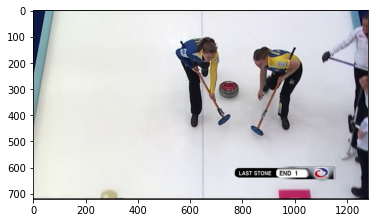

In [24]:
# Visualize image
img_name = matfile['NAME'][image_id]

img = cv2.imread(f'{TRAIN_ROOT_PATH}/images/{img_name}', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
plt.imshow(img)
plt.show()

In [25]:
# Get Body joints
print('Body')
sample_data = matfile.iloc[image_id,1:-3]
joint = [[0, 0]] * 16
for i in range(0, 32, 2):
    if sample_data[i] == -1 or sample_data[i+1] == -1: continue
    joint[i//2] = [int(sample_data[i]), int(sample_data[i+1])]
print(joint)

Body
[[620, 394], [616, 269], [573, 185], [647, 188], [661, 221], [656, 231], [610, 187], [647, 176], [637, 189], [695, 108], [606, 217], [553, 161], [601, 167], [692, 185], [693, 240], [688, 313]]


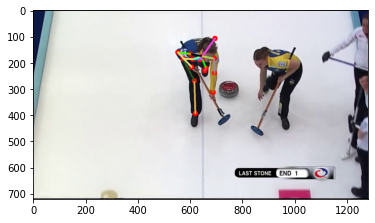

In [26]:
# Draw Posture
for idx, j in enumerate(joint):
#     if idx == 10: color = (0, 0, 255)
#     else: color = (255, 0, 0)
    cv2.circle(img=img, center=(int(j[0]), int(j[1])), radius=10, color=(255, 0, 0), thickness=-1)
    img = drawPose(img, joint)
plt.imshow(img)

In [27]:
matfile.head()

,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,pelvis_X,pelvis_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r wrist_X,r wrist_Y,r elbow_X,r elbow_Y,r shoulder_X,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,015601864.jpg,620,394,616,269,573,185,647,188,661,221,656,231,610,187,647,176,637.0201,189.8183,695.9799,108.1817,606,217,553,161,601,167,692,185,693,240,688,313,3.021046,curling,sports
1,015599452.jpg,-1,-1,-1,-1,806,543,720,593,-1,-1,-1,-1,763,568,683,290,682.0000,256.0000,676.0000,68.0000,563,296,555,410,647,281,719,299,711,516,545,466,5.641276,curling,sports
2,005808361.jpg,804,711,816,510,908,438,1040,454,906,528,883,707,974,446,985,253,982.7591,235.9694,962.2409,80.0306,869,214,798,340,902,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,086617615.jpg,301,461,305,375,201,340,294,342,335,370,331,455,248,341,279,263,277.0210,268.7786,305.9790,184.2214,328,354,260,335,244,261,314,264,327,320,362,346,2.681349,curling,sports
4,060111501.jpg,980,322,896,318,865,248,943,226,948,290,881,349,904,237,858,135,871.1877,180.4244,835.8123,58.5756,772,294,754,247,792,147,923,123,995,163,961,223,3.806403,curling,sports


In [28]:
img_name, label, box_w, box_h, x1, y1, x2, y2 = [], [], [], [], [], [], [], []
div = []
width, height = [], []

for i in tqdm(range(len(matfile))):
    flag = 0
    randomNum = np.random.rand()
    if randomNum < 0.3: flag = 1
    
    xMax = max(np.array(matfile.iloc[i, 1:-3:2]))
    xMin = min(np.array(matfile.iloc[i, 1:-3:2][matfile.iloc[i, 1:-3:2]>0]))
    yMax = max(np.array(matfile.iloc[i, 2:-3:2]))
    yMin = min(np.array(matfile.iloc[i, 2:-3:2][matfile.iloc[i, 2:-3:2]>0]))
    deltaX = xMax - xMin
    deltaY = yMax - yMin

    # Joint data
    for j in range(16):
        xCenter = matfile.iloc[i, 1 + 2 * j]
        yCenter = matfile.iloc[i, 2 + 2 * j]
        if xCenter <= 0 or yCenter <= 0: continue
        
        img_name.append(matfile.iloc[i, 0])
        
        img = cv2.imread(f'{TRAIN_ROOT_PATH}/images/{matfile.iloc[i, 0]}', cv2.IMREAD_COLOR)
        height.append(img.shape[0])
        width.append(img.shape[1])
        
        label.append(j)        
        if deltaX // 2 - deltaY > 0:
            w = deltaX//20; h = deltaY//10
        elif deltaY // 2 - deltaX > 0:
            w = deltaX//10; h = deltaY//20
        else:
            w = deltaX//10; h = deltaY//10
            
        if w < 5: w = 5
        if h < 5: h = 5
        box_w.append(int(w))
        box_h.append(int(h))
        
       
        x1.append(int(max(xCenter - w//2, 0)))
        y1.append(int(max(yCenter - h//2, 0)))
        x2.append(int(min(xCenter + w//2, img.shape[1] - 1)))
        y2.append(int(min(yCenter + h//2, img.shape[0] - 1)))
        
        div.append(flag)
    
    # Human BBox
    img_name.append(matfile.iloc[i, 0])
    label.append(16)
    box_w.append(int(deltaX))
    box_h.append(int(deltaY))
    
    xMean = np.mean(np.array(matfile.iloc[i, 1:-3:2]))
    yMean = np.mean(np.array(matfile.iloc[i, 2:-3:2]))
    
    x1.append(int(xMin))
    y1.append(int(yMin))
    x2.append(int(xMax))
    y2.append(int(yMax))
    
    height.append(img.shape[0])
    width.append(img.shape[1])
    
    div.append(flag)
    
image_info = pd.DataFrame({'name': img_name,
                                'label': label,
                                'width': width,
                                'height': height,
                                'box_width': box_w,
                                'box_height': box_h,
                                'x1': x1,
                                'y1': y1,
                                'x2': x2,
                                'y2': y2,
                          'test' : div})

100%|██████████| 17372/17372 [50:35<00:00,  5.72it/s] 


In [29]:
image_info.head()

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
0,015601864.jpg,0,1280,720,14,28,613,380,627,408,0
1,015601864.jpg,1,1280,720,14,28,609,255,623,283,0
2,015601864.jpg,2,1280,720,14,28,566,171,580,199,0
3,015601864.jpg,3,1280,720,14,28,640,174,654,202,0
4,015601864.jpg,4,1280,720,14,28,654,207,668,235,0


In [30]:
image_info.describe()

,label,width,height,box_width,box_height,x1,y1,x2,y2,test
count,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000,274956.000000
mean,8.373031,1327.444748,769.329333,42.281045,61.505343,623.472916,358.562210,665.268105,419.435662,0.301117
std,4.814774,428.910383,216.664039,78.676964,116.756747,322.084720,200.465105,329.968111,210.506374,0.458744
min,0.000000,272.000000,408.000000,5.000000,5.000000,0.000000,0.000000,4.000000,6.000000,0.000000
25%,4.000000,1280.000000,720.000000,15.000000,21.000000,379.000000,211.000000,414.000000,263.000000,0.000000
50%,9.000000,1280.000000,720.000000,23.000000,31.000000,584.000000,328.500000,626.000000,385.000000,0.000000
75%,13.000000,1920.000000,1080.000000,37.000000,49.000000,821.000000,476.000000,869.000000,546.000000,1.000000
max,16.000000,1920.000000,1080.000000,1808.000000,1099.000000,1913.000000,1143.000000,1921.000000,1170.000000,1.000000


In [31]:
image_info[image_info['test'] == 1]

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
97,002058449.jpg,0,1280,720,78,39,879,437,957,475,1
98,002058449.jpg,1,1280,720,78,39,620,499,698,537,1
99,002058449.jpg,2,1280,720,78,39,674,394,752,432,1
100,002058449.jpg,3,1280,720,78,39,940,269,1018,307,1
101,002058449.jpg,4,1280,720,78,39,1183,434,1261,472,1
...,...,...,...,...,...,...,...,...,...,...,...
274934,039361034.jpg,12,720,480,21,13,431,247,451,259,1
274935,039361034.jpg,13,720,480,21,13,456,245,476,257,1
274936,039361034.jpg,14,720,480,21,13,426,287,446,299,1
274937,039361034.jpg,15,720,480,21,13,400,319,420,331,1


In [48]:
for idx in image_info[image_info['width']<=image_info['x2']].index:
    image_info.iloc[idx, 8] = image_info.iloc[idx, 2] - 1

In [49]:
for idx in image_info[image_info['height']<=image_info['y2']].index:
    image_info.iloc[idx, 9] = image_info.iloc[idx, 3] - 1

In [59]:
for idx in image_info[image_info['width']<=image_info['x1']].index:
    image_info.iloc[idx, 6] = image_info.iloc[idx, 2] - 1

In [60]:
for idx in image_info[image_info['height']<=image_info['y1']].index:
    image_info.iloc[idx, 7] = image_info.iloc[idx, 3] - 1

In [73]:
image_info = image_info.drop(image_info[image_info['x2']<=image_info['x1']].index)

In [74]:
image_info = image_info.drop(image_info[image_info['y2']<=image_info['y1']].index)

In [75]:
train_data = image_info[image_info['test'] == 0]

In [76]:
test_data = image_info[image_info['test'] == 1]

In [77]:
train_data.head()

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
0,015601864.jpg,0,1280,720,14,28,613,380,627,408,0
1,015601864.jpg,1,1280,720,14,28,609,255,623,283,0
2,015601864.jpg,2,1280,720,14,28,566,171,580,199,0
3,015601864.jpg,3,1280,720,14,28,640,174,654,202,0
4,015601864.jpg,4,1280,720,14,28,654,207,668,235,0


In [78]:
test_data.head()

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
97,002058449.jpg,0,1280,720,78,39,879,437,957,475,1
98,002058449.jpg,1,1280,720,78,39,620,499,698,537,1
99,002058449.jpg,2,1280,720,78,39,674,394,752,432,1
100,002058449.jpg,3,1280,720,78,39,940,269,1018,307,1
101,002058449.jpg,4,1280,720,78,39,1183,434,1261,472,1


In [79]:
train_data.to_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/train_dataset.csv', index=False)
test_data.to_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/test_dataset.csv', index=False)

In [68]:
image_info[image_info['x2']<=image_info['x1']]

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
140811,052008994.jpg,5,1280,720,11,15,1279,478,1279,492,1
172021,011121658.jpg,9,640,480,22,21,639,283,639,303,0


In [69]:
image_info[image_info['y2']<=image_info['y1']]

,name,label,width,height,box_width,box_height,x1,y1,x2,y2,test
54619,043539632.jpg,5,1280,720,36,61,531,719,567,719,0
57274,050463729.jpg,3,1280,720,33,65,695,719,727,719,0
86981,068058309.jpg,1,1280,720,44,72,424,719,468,719,1
86984,068058309.jpg,4,1280,720,44,72,862,719,906,719,1
87065,090125921.jpg,1,1280,720,44,74,492,719,536,719,0
87068,090125921.jpg,4,1280,720,44,74,701,719,745,719,0
89126,005226867.jpg,1,1280,720,57,63,616,719,672,719,1
140303,059248640.jpg,1,1920,1080,51,54,764,1079,814,1079,0
140306,059248640.jpg,4,1920,1080,51,54,1024,1079,1074,1079,0
162861,039940030.jpg,1,1280,720,37,70,432,719,468,719,0


In [ ]:
image_info[image_info]